Credits to Elissaios Sarmas for the code, which was adapted for use on this dataset (credits to Xiaomin Chang). Code can be found here: https://github.com/ElissaiosSarmas/Transfer-learning-strategies-for-solar-power-forecasting-under-data-scarcity

In [21]:
# Clear any logs from previous runs
!rm -r ./LSTM_w_TL_1/logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
import datetime, os

from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras_layer_normalization import LayerNormalization
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras import Input,Model
from tensorflow.keras.models import load_model
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK, STATUS_FAIL, space_eval
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [23]:
path = "C:/work/Honours code/Datasets/all_data.csv"

p1 = pd.read_csv(path, header=0)

In [24]:
p1_copy = p1.copy()
p1_copy['timestamp'] = pd.to_datetime(p1['period_end'], format='ISO8601')

p1_copy.drop(['period_end'], axis=1, inplace=True)

# dropping columns that are not needed
p1_copy.drop(['Unnamed: 0', 'period_x', 'period_y', '_id_x', '_id_y'], axis=1, inplace=True)

# make the timestamp the first column
timestamp = p1_copy.pop('timestamp')
p1_copy.insert(0, 'timestamp', timestamp)

# extract the hour and month from the timestamp
p1_copy['hour'] = pd.to_datetime(p1_copy['timestamp']).dt.hour
p1_copy['month'] = pd.to_datetime(p1_copy['timestamp']).dt.month

In [25]:
p1_copy.head()

,timestamp,ghi,ghi90,ghi10,ebh,dni,dni10,dni90,dhi,air_temp,zenith,azimuth,cloud_opacity,pv_estimate,hour,month
0,2018-07-30 11:30:00+00:00,0,0,0,0,0,0,0,0,13,140,102,0,0.0,11,7
1,2018-07-30 12:00:00+00:00,0,0,0,0,0,0,0,0,13,146,108,0,0.0,12,7
2,2018-07-30 12:30:00+00:00,0,0,0,0,0,0,0,0,13,152,116,0,0.0,12,7
3,2018-07-30 13:00:00+00:00,0,0,0,0,0,0,0,0,12,157,127,1,0.0,13,7
4,2018-07-30 13:30:00+00:00,0,0,0,0,0,0,0,0,12,162,143,1,0.0,13,7


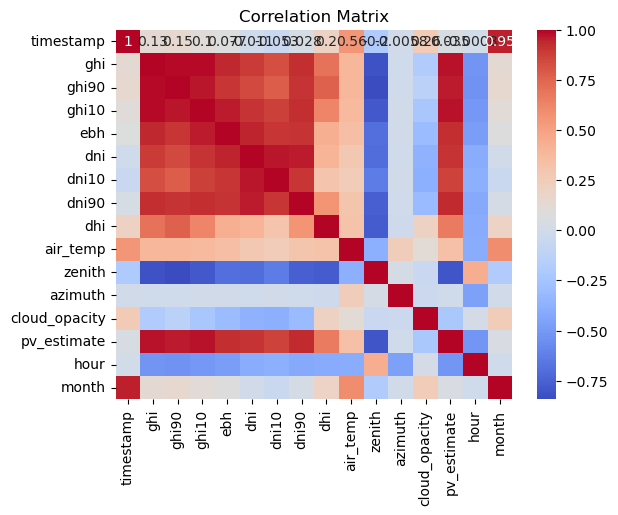

In [26]:
corr_matrix = p1_copy.corr()
# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The first few variables seem highly correlated. Let's try removing the variables with angles and see if it improves visually.

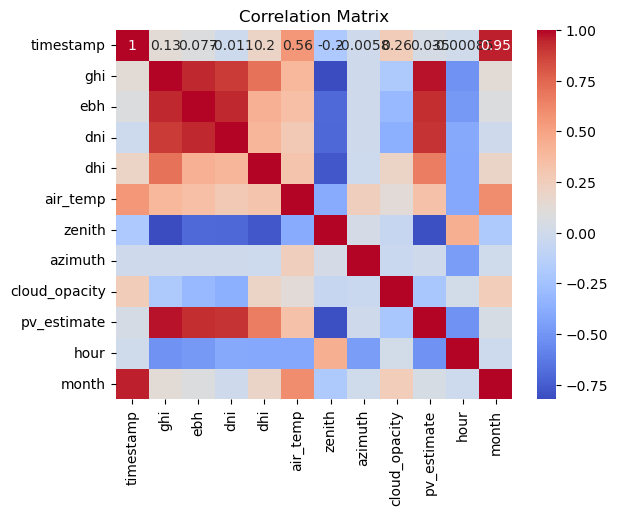

In [27]:
cols_to_keep = ['timestamp', 'ghi', 'ebh', 'dni', 'dhi', 'air_temp', 'zenith', 'azimuth', 'cloud_opacity', 'pv_estimate', 'hour', 'month']
corr_plot2 = p1_copy[cols_to_keep]
corr_mat2 = corr_plot2.corr()
# Plot the correlation matrix
sns.heatmap(corr_mat2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

It does seem to improve visually, so we'll drop those variables.

In [28]:
p1_copy_2 = p1_copy.drop(['ghi90', 'ghi10', 'dni10', 'dni90'], axis=1)

In [29]:

# Perform One-Hot-Encoding for Months and Sin-Cos Similarities for Hours
data = p1_copy_2
data['timestamp'] = pd.to_numeric(data['timestamp'])
#data = pd.get_dummies(data, columns=['month'])
data.loc[:,'sin_hour'] = np.sin(2*np.pi*data['timestamp']/24)
data.loc[:,'cos_hour'] = np.cos(2*np.pi*data['timestamp']/24)

print("Total Entries =", len(data))

Total Entries = 3705


In [30]:
# Shaping data for LSTM input
def split_sequences(sequences, n_steps, n_outputs, only_production, validation_split):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern 
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + n_outputs > len(sequences):
            break
        # gather input and output parts of the pattern
        if only_production==True:
            seq_x, seq_y = sequences[i:end_ix, -1], sequences[end_ix:(end_ix+n_outputs), -1]
        else:
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:(end_ix+n_outputs), -1]
            
        X.append(seq_x)
        y.append(seq_y)
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [31]:
def unique_shapes(x, y, lag_, n_features_, num_of_outputs_, only_production, validation_split):
    unique_shapes = []
    for k in range(len(x)):
        if only_production==True:
            if (x[k].shape == (lag,)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)
        else:
            if (x[k].shape == (lag_, n_features_)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)       
    x = x[unique_shapes]
    y = y[unique_shapes]
    x = np.stack(x)
    y = np.stack(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [32]:
cols = data.columns.tolist()
cols

['timestamp',
 'ghi',
 'ebh',
 'dni',
 'dhi',
 'air_temp',
 'zenith',
 'azimuth',
 'cloud_opacity',
 'pv_estimate',
 'hour',
 'month',
 'sin_hour',
 'cos_hour']

In [33]:
# Select the columns that you want to use as features
cols = ['timestamp',
 'ghi',
 'ebh',
 'dhi',
 'air_temp',
 'azimuth',
 'cloud_opacity',
 'sin_hour',
 'cos_hour',
 'pv_estimate']
# I need to have 10 features to match the padding. I'll remove hour, month, dni and zenith.

# Set to True if using only the production, else to False
only_production = False
# Splitting factor for training set and test set
split = 0.4

# Select the lag variable, the number of features (must be same with cols selected) and the horizon
lag = 5
n_features = len(cols)
num_of_outputs = 1

Padding the data to match the domain dataset

In [34]:
timesteps = 5
features = 10
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_array = data['timestamp'].values
# flatten the data
data_array = data_array.reshape(-1)
total_features = ((len(data_array) // (timesteps * features)) + 1) * (timesteps * features)
# calculate the padding
padding = total_features - len(data_array)
# pad the data
data_padded = np.pad(data_array, (0, padding), 'constant')

# Reshape the data
data_padded = data_padded.reshape(-1, timesteps, features)

print(data_padded.shape)

(75, 5, 10)


In [35]:
# Scale data seperately
from sklearn.preprocessing import MinMaxScaler

if only_production == True:
    data_ = data_['SystemProduction']
    train = data_.iloc[:int(len(data_)*split_),]
    test = data_.iloc[int(len(data_)*split_):,]
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train.values.reshape(-1, 1))
    test = scaler.fit_transform(test.values.reshape(-1, 1))
else:
    # convert numpy array to pandas dataframe
    # data = pd.DataFrame(data_padded.reshape(-1, features))
    # flatten the data
    data = data_padded.reshape(-1, len(cols))
    print(data.shape)
    data = pd.DataFrame(data, columns=cols)
    data = data[cols]
    train = data.iloc[:int(len(data)*split),:]
    test = data.iloc[int(len(data)*split):,]
    scaler = MinMaxScaler(feature_range=(0,1))
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)

(375, 10)


In [36]:
# Create the input for LSTM: x(batch_size, lag, features), y(batch_size,)

x_train, x_val, y_train, y_val = split_sequences(train, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = split_sequences(test, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)

x_train, x_val, y_train, y_val = unique_shapes(x_train, y_train, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = unique_shapes(x_test, y_test, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)


# Reshape for only_production case
if only_production:
    x_train = x_train.reshape((x_train.shape[0], lag, 1))
    x_test = x_test.reshape((x_test.shape[0], lag, 1))
else:
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
# Print the shapes
print("Size of Train / Test =", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Size of Train / Test = (52, 5, 10) (52, 1) (79, 5, 10) (79, 1)


In [37]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))



base_model_path = "C:/work/Honours code/Transfer learning/LSTM/model/LSTM_base.h5"

def createModel():

    # BI-LSTM Model Architecture

    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    new_model = Model(inputs=model.inputs, outputs=output)
    #new_model = Model(inputs=model.inputs)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = new_model(inputs, training=False)
    # x = model(inputs, training=False)
    print("Input shape:", x_train.shape)
    x = Bidirectional(LSTM(16, activation="relu", return_sequences=False))(x)
    x = Dropout(0.27)(x)

    # x = Dense(500, activation="relu")(x)
    outputs  = Dense(1)(x)

    new_model = Model(inputs, outputs)

    # Compile model
    optimizer = Adam(learning_rate=0.00083)
    new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    new_model.summary()

    return new_model

In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from keras.layers import TFSMLayer
from tensorflow.keras import backend as K
import h5py
import os
import time
timestamp = int(time.time())
true_values = []
predicted_values = []
model_path = "LSTM_model_1.h5"
K.clear_session()
def fit_predict_stats(model):
    # Early stopping property
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    tb = TensorBoard(log_dir='logs')
    experiment_name = 'run_3'
    log_dir = f'./logs/{experiment_name}'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    # Model fine-tuning
    model.trainable = True
    model.layers[0].trainable = True
    model.layers[1].trainable = True
    optimizer = Adam(learning_rate=0.0001) # Decreasing the learning rate to prevent overfitting
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    if os.path.exists(model_path):
        
    # Load the model
        tf.debugging.set_log_device_placement(True)
        model = load_model(model_path)
    else:
        # Model file does not exist, so save the model
        
        # Fit the model
        
        model.save(model_path, overwrite=True)

    
    # summarize history for MAE and MSE
    # plt.plot(history['loss'])
    # plt.plot(history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('Model MSE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # plt.figure()
    # plt.plot(history['mae'])
    # plt.plot(history['val_mae'])
    # plt.title('Model MAE')
    # plt.ylabel('MAE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # Metrics on scaled data
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    y_pred = model.predict(x_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    # print('Train Scaled RMSE: {}'.format(rmse))
    # print('Train Scaled MAE: {}'.format(mae))
    # print('Train Scaled R2 Score: ', r2_score(y_train, y_pred)*100)

    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    # print('Test Scaled RMSE: {}'.format(rmse))
    # print('Test Scaled MAE: {}'.format(mae))
    # print('Test Scaled R2 Score: ',r2_score(y_test, y_pred)*100)


    
    # Metrics on original data
    true = []
    hat = []
    range_ = [0]
    # range_ = list(range(6))

    for i,j in zip([[x_train,y_train],[x_test,y_test]],['Train','Test']):
        # make a prediction
        yhat = model.predict(i[0])
        if yhat.shape == (yhat.shape[0],):
            yhat = yhat.reshape((yhat.shape[0],1))  
      
        y_hat = []
        for k in range(len(yhat)):
            if k == 0:
                for l in range_:
                    y_hat.append(yhat[k,l])
            else:
                y_hat.append(yhat[k,-1])
        
        y_hat = np.stack(y_hat)
        y_hat = y_hat.reshape((y_hat.shape[0],1))

        ### trying to resolve the issue of different shapes
        total_elements = np.product(i[0].shape)
        lag = i[0].shape[1]
        n_features = i[0].shape[2]
        print("Total elements in data:", total_elements)
        ###
        
        i[0] = i[0].reshape((i[0].shape[0],lag,n_features))
        
        x_hat = []
        for k in range(len(i[0])):
            if k == 0:
                x_hat.append(i[0][k])
            elif k!= 0:
                x_hat.append(i[0][k][-1,:])
        
        x_hat = np.vstack(x_hat)
        
        initial_x_hat_shape = x_hat.shape[0]
        initial_y_hat_shape = y_hat.shape[0]
        
        print(x_hat.shape)
        print(y_hat.shape)
        
        if x_hat.shape[0]-y_hat.shape[0] != 0.0:
            if x_hat.shape[0] > y_hat.shape[0]:
                for k in range(x_hat.shape[0]-y_hat.shape[0]):
                    y_hat = np.insert(y_hat, 0, y_hat[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_hat.shape[0]:
                y_hat = y_hat[-int(x_hat.shape[0]-y_hat.shape[0]):,:]
                added_values = False
        
        print(x_hat[:,:-1].shape)
        print(y_hat.shape)
        
        # invert scaling for forecast
        if only_production==True:
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
        else:    
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            
        # invert scaling for actual
        y_true = []
        for k in range(len(i[1])):
            if k ==0:
                for l in range_:
                    y_true.append(i[1][k,l])
            else:
                y_true.append(i[1][k,-1])

        y_true = np.stack(y_true)
        y_true = y_true.reshape((y_true.shape[0],1))
        print(y_true.shape)

        initial_y_true_shape = y_true.shape[0]
        
        if x_hat.shape[0]-y_true.shape[0] != 0.0:
            if x_hat.shape[0] > y_true.shape[0]:
                for k in range(x_hat.shape[0]-y_true.shape[0]):
                    y_true = np.insert(y_true, 0, y_true[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_true.shape[0]:
                y_true = y_true[-int(x_hat.shape[0]-y_true.shape[0]):,:]
                added_values = False
                
        if only_production==True:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
        else:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,-1]
        
        true.append(inv_y)
        hat.append(inv_yhat)

        # true_values.append(true)
        # predicted_values.append(hat)
        
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate MAE
        mae = mean_absolute_error(inv_y, inv_yhat)
        print('Test MAE: %.3f' % mae)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print('Test R2 Score: ',r2)
        # Calculate MAPE
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        print('MAPE', mape)
        # Calculate MBE
        mbe = np.mean(inv_yhat - inv_y)
        print('Test MBE', mbe)
        # Calculate nRMSE
        nRMSE = rmse / np.mean(inv_y)
        print('nRMSE', nRMSE)

        



    mae_list.append(mae)
    rmse_list.append(rmse)
    r_square_list.append(r2)
    mape_list.append(mape)
    mbe_list.append(mbe)
    nRMSE_list.append(nRMSE)



In [39]:
mae_list = []
rmse_list = []
r_square_list = []
mape_list = []
mbe_list = []
nRMSE_list = []
num_iterations = 20
#num_iterations = 2
for i in range(num_iterations):
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of y_test:", y_test.shape)
    model = createModel()
    keras.config.disable_traceback_filtering()
    fit_predict_stats(model)

# sns.set_style("darkgrid")
# for true, hat in zip(true_values, predicted_values):
#     plt.figure()
#     plt.plot(true[1], color="green")
#     plt.plot(hat[1], color="red")
#     plt.savefig('plots/lstm_base_plot.png')
    #plt.show()

print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("R^2:", r_square_list)
print("MAPE:", mape_list)
print("MBE:", mbe_list)
print("nRMSE:", nRMSE_list)

print("Mean MAE:", np.mean(mae_list))
print("Mean RMSE:", np.mean(rmse_list))
print("Mean R^2:", np.mean(r_square_list))
print("Mean MAPE:", np.mean(mape_list))
print("Mean MBE:", np.mean(mbe_list))
print("Mean nRMSE:", np.mean(nRMSE_list))


Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.3573 - mae: 0.5397 - val_loss: 0.1473 - val_mae: 0.3309
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2887 - mae: 0.4832 - val_loss: 0.1038 - val_mae: 0.2784
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1802 - mae: 0.3865 - val_loss: 0.0683 - val_mae: 0.2266
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0962 - mae: 0.2799 - val_loss: 0.0377 - val_mae: 0.1694
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0766 - mae: 0.2439 - val_loss: 0.0147 - val_mae: 0.1075
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0427 - mae: 0.1701 - val_loss: 0.0037 - val_mae: 0.0537
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0312 - mae: 0.1289 - val_loss: 0.0028 - val_mae: 0.0393
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0835 - mae: 0.2005 - val_loss: 0.0024 - val_mae: 0.0372
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0568 - mae: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_17 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.3590 - mae: 0.5421 - val_loss: 0.1603 - val_mae: 0.3455
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2363 - mae: 0.4405 - val_loss: 0.1120 - val_mae: 0.2892
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1589 - mae: 0.3684 - val_loss: 0.0657 - val_mae: 0.2223
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0515 - mae: 0.2026 - val_loss: 0.0285 - val_mae: 0.1480
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0413 - mae: 0.1652 - val_loss: 0.0067 - val_mae: 0.0710
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0284 - mae: 0.1203 - val_loss: 0.0023 - val_mae: 0.0387
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0537 - mae: 0.1495 - val_loss: 0.0021 - val_mae: 0.0345
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0421 - mae: 0.1323 - val_loss: 0.0016 - val_mae: 0.0344
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0231 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_27 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.3415 - mae: 0.5278 - val_loss: 0.1582 - val_mae: 0.3425
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2493 - mae: 0.4557 - val_loss: 0.1109 - val_mae: 0.2876
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1791 - mae: 0.3858 - val_loss: 0.0699 - val_mae: 0.2293
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1321 - mae: 0.3235 - val_loss: 0.0359 - val_mae: 0.1654
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0633 - mae: 0.2078 - val_loss: 0.0123 - val_mae: 0.0977
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0420 - mae: 0.1585 - val_loss: 0.0032 - val_mae: 0.0494
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0398 - mae: 0.1312 - val_loss: 0.0035 - val_mae: 0.0408
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0651 - mae: 0.1734 - val_loss: 0.0026 - val_mae: 0.0385
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0569 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_37 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.4562 - mae: 0.6069 - val_loss: 0.2061 - val_mae: 0.3896
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3694 - mae: 0.5488 - val_loss: 0.1722 - val_mae: 0.3560
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2993 - mae: 0.4952 - val_loss: 0.1429 - val_mae: 0.3242
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2253 - mae: 0.4346 - val_loss: 0.1133 - val_mae: 0.2890
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1850 - mae: 0.3872 - val_loss: 0.0806 - val_mae: 0.2444
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1025 - mae: 0.2799 - val_loss: 0.0478 - val_mae: 0.1906
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0795 - mae: 0.2440 - val_loss: 0.0202 - val_mae: 0.1255
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0903 - mae: 0.2284 - val_loss: 0.0077 - val_mae: 0.0765
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0945 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_47 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.3555 - mae: 0.5353 - val_loss: 0.1442 - val_mae: 0.3291
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2289 - mae: 0.4371 - val_loss: 0.0997 - val_mae: 0.2750
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1440 - mae: 0.3417 - val_loss: 0.0590 - val_mae: 0.2136
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0896 - mae: 0.2608 - val_loss: 0.0258 - val_mae: 0.1427
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0655 - mae: 0.2112 - val_loss: 0.0094 - val_mae: 0.0840
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0825 - mae: 0.1734 - val_loss: 0.0065 - val_mae: 0.0679
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0427 - mae: 0.1470 - val_loss: 0.0072 - val_mae: 0.0735
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0685 - mae: 0.1764 - val_loss: 0.0092 - val_mae: 0.0841
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0496 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_57 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 0.3729 - mae: 0.5551 - val_loss: 0.1719 - val_mae: 0.3581
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2946 - mae: 0.4934 - val_loss: 0.1291 - val_mae: 0.3112
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1922 - mae: 0.3962 - val_loss: 0.0881 - val_mae: 0.2583
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1039 - mae: 0.2811 - val_loss: 0.0476 - val_mae: 0.1914
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0723 - mae: 0.2163 - val_loss: 0.0197 - val_mae: 0.1244
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0648 - mae: 0.1849 - val_loss: 0.0064 - val_mae: 0.0689
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0307 - mae: 0.1158 - val_loss: 0.0034 - val_mae: 0.0487
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0653 - mae: 0.1834 - val_loss: 0.0028 - val_mae: 0.0448
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0890 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_67 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - loss: 0.4886 - mae: 0.6345 - val_loss: 0.2648 - val_mae: 0.4391
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4628 - mae: 0.6135 - val_loss: 0.2250 - val_mae: 0.4044
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3830 - mae: 0.5657 - val_loss: 0.1892 - val_mae: 0.3705
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3009 - mae: 0.4963 - val_loss: 0.1586 - val_mae: 0.3387
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2487 - mae: 0.4536 - val_loss: 0.1265 - val_mae: 0.3022
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2211 - mae: 0.4150 - val_loss: 0.0928 - val_mae: 0.2587
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1175 - mae: 0.3156 - val_loss: 0.0592 - val_mae: 0.2083
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0813 - mae: 0.2425 - val_loss: 0.0289 - val_mae: 0.1477
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0404 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_77 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.3657 - mae: 0.5465 - val_loss: 0.1816 - val_mae: 0.3650
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2895 - mae: 0.4889 - val_loss: 0.1330 - val_mae: 0.3126
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2051 - mae: 0.4123 - val_loss: 0.0897 - val_mae: 0.2571
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1191 - mae: 0.3100 - val_loss: 0.0497 - val_mae: 0.1931
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0573 - mae: 0.2011 - val_loss: 0.0210 - val_mae: 0.1279
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0718 - mae: 0.2109 - val_loss: 0.0061 - val_mae: 0.0664
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0335 - mae: 0.1269 - val_loss: 0.0028 - val_mae: 0.0469
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0413 - mae: 0.1438 - val_loss: 0.0023 - val_mae: 0.0419
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0530 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_87 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.4069 - mae: 0.5785 - val_loss: 0.1909 - val_mae: 0.3752
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2972 - mae: 0.4965 - val_loss: 0.1440 - val_mae: 0.3259
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2154 - mae: 0.4197 - val_loss: 0.0999 - val_mae: 0.2717
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1433 - mae: 0.3430 - val_loss: 0.0585 - val_mae: 0.2092
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0945 - mae: 0.2569 - val_loss: 0.0251 - val_mae: 0.1397
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0302 - mae: 0.1448 - val_loss: 0.0057 - val_mae: 0.0654
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0543 - mae: 0.1632 - val_loss: 0.0052 - val_mae: 0.0470
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1499 - mae: 0.2346 - val_loss: 0.0063 - val_mae: 0.0469
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0884 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_97 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.3115 - mae: 0.5033 - val_loss: 0.1425 - val_mae: 0.3249
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2040 - mae: 0.4104 - val_loss: 0.0933 - val_mae: 0.2637
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1450 - mae: 0.3462 - val_loss: 0.0497 - val_mae: 0.1935
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0647 - mae: 0.2104 - val_loss: 0.0172 - val_mae: 0.1161
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0290 - mae: 0.1303 - val_loss: 0.0041 - val_mae: 0.0563
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0555 - mae: 0.1511 - val_loss: 0.0025 - val_mae: 0.0422
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0512 - mae: 0.1519 - val_loss: 0.0025 - val_mae: 0.0451
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0545 - mae: 0.1392 - val_loss: 0.0052 - val_mae: 0.0634
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0441 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_107 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.3829 - mae: 0.5623 - val_loss: 0.1887 - val_mae: 0.3735
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3032 - mae: 0.4995 - val_loss: 0.1469 - val_mae: 0.3296
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2171 - mae: 0.4232 - val_loss: 0.1037 - val_mae: 0.2776
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1411 - mae: 0.3454 - val_loss: 0.0618 - val_mae: 0.2155
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0709 - mae: 0.2298 - val_loss: 0.0258 - val_mae: 0.1416
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0369 - mae: 0.1626 - val_loss: 0.0064 - val_mae: 0.0692
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0568 - mae: 0.1566 - val_loss: 0.0035 - val_mae: 0.0502
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0921 - mae: 0.1969 - val_loss: 0.0035 - val_mae: 0.0534
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0889 - mae:

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_117 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.2367 - mae: 0.4394 - val_loss: 0.0891 - val_mae: 0.2599
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1365 - mae: 0.3374 - val_loss: 0.0470 - val_mae: 0.1903
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0649 - mae: 0.2238 - val_loss: 0.0159 - val_mae: 0.1120
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0408 - mae: 0.1563 - val_loss: 0.0027 - val_mae: 0.0458
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0329 - mae: 0.1365 - val_loss: 0.0028 - val_mae: 0.0344
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0509 - mae: 0.1527 - val_loss: 0.0024 - val_mae: 0.0323
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0280 - mae: 0.1187 - val_loss: 0.0015 - val_mae: 0.0324
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0442 - mae: 0.1244 - val_loss: 0.0031 - val_mae: 0.0473
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0202 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_127 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.5188 - mae: 0.6483 - val_loss: 0.2524 - val_mae: 0.4287
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3947 - mae: 0.5710 - val_loss: 0.2066 - val_mae: 0.3876
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3495 - mae: 0.5357 - val_loss: 0.1647 - val_mae: 0.3455
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2471 - mae: 0.4476 - val_loss: 0.1264 - val_mae: 0.3021
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1720 - mae: 0.3697 - val_loss: 0.0873 - val_mae: 0.2515
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1073 - mae: 0.2908 - val_loss: 0.0500 - val_mae: 0.1922
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0462 - mae: 0.1887 - val_loss: 0.0192 - val_mae: 0.1212
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0324 - mae: 0.1428 - val_loss: 0.0033 - val_mae: 0.0516
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0385 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_137 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.4280 - mae: 0.5950 - val_loss: 0.2233 - val_mae: 0.4053
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3259 - mae: 0.5208 - val_loss: 0.1862 - val_mae: 0.3700
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2777 - mae: 0.4805 - val_loss: 0.1474 - val_mae: 0.3297
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1970 - mae: 0.4067 - val_loss: 0.1078 - val_mae: 0.2829
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1503 - mae: 0.3454 - val_loss: 0.0691 - val_mae: 0.2279
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0901 - mae: 0.2646 - val_loss: 0.0335 - val_mae: 0.1617
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0511 - mae: 0.1894 - val_loss: 0.0100 - val_mae: 0.0844
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0300 - mae: 0.1398 - val_loss: 0.0053 - val_mae: 0.0577
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1219 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 6s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_147 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.5311 - mae: 0.6578 - val_loss: 0.2902 - val_mae: 0.4586
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.4810 - mae: 0.6298 - val_loss: 0.2332 - val_mae: 0.4109
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4054 - mae: 0.5755 - val_loss: 0.1857 - val_mae: 0.3664
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2959 - mae: 0.4912 - val_loss: 0.1413 - val_mae: 0.3192
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1926 - mae: 0.3971 - val_loss: 0.0991 - val_mae: 0.2679
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1539 - mae: 0.3386 - val_loss: 0.0606 - val_mae: 0.2114
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0527 - mae: 0.2005 - val_loss: 0.0287 - val_mae: 0.1475
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0649 - mae: 0.2090 - val_loss: 0.0117 - val_mae: 0.0961
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0519 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_157 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.3670 - mae: 0.5478 - val_loss: 0.1894 - val_mae: 0.3728
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2839 - mae: 0.4856 - val_loss: 0.1436 - val_mae: 0.3244
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2229 - mae: 0.4288 - val_loss: 0.1013 - val_mae: 0.2721
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1520 - mae: 0.3348 - val_loss: 0.0569 - val_mae: 0.2054
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1032 - mae: 0.2695 - val_loss: 0.0193 - val_mae: 0.1219
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0514 - mae: 0.1708 - val_loss: 0.0046 - val_mae: 0.0605
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0590 - mae: 0.1669 - val_loss: 0.0028 - val_mae: 0.0478
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0658 - mae: 0.1708 - val_loss: 0.0034 - val_mae: 0.0524
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0349 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_167 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.4272 - mae: 0.5932 - val_loss: 0.2219 - val_mae: 0.4026
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3600 - mae: 0.5405 - val_loss: 0.1857 - val_mae: 0.3683
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3125 - mae: 0.5049 - val_loss: 0.1511 - val_mae: 0.3322
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2237 - mae: 0.4298 - val_loss: 0.1164 - val_mae: 0.2918
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1724 - mae: 0.3784 - val_loss: 0.0814 - val_mae: 0.2447
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1069 - mae: 0.2941 - val_loss: 0.0487 - val_mae: 0.1911
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0753 - mae: 0.2301 - val_loss: 0.0217 - val_mae: 0.1296
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0327 - mae: 0.1522 - val_loss: 0.0062 - val_mae: 0.0686
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0921 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_177 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.3004 - mae: 0.4956 - val_loss: 0.1342 - val_mae: 0.3175
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1721 - mae: 0.3804 - val_loss: 0.0766 - val_mae: 0.2417
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0903 - mae: 0.2626 - val_loss: 0.0305 - val_mae: 0.1545
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0531 - mae: 0.1935 - val_loss: 0.0067 - val_mae: 0.0693
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0469 - mae: 0.1403 - val_loss: 0.0029 - val_mae: 0.0455
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0416 - mae: 0.1392 - val_loss: 0.0027 - val_mae: 0.0459
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0917 - mae: 0.1813 - val_loss: 0.0056 - val_mae: 0.0655
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0429 - mae: 0.1480 - val_loss: 0.0115 - val_mae: 0.0943
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0352 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (52, 5, 10)


Model: "functional_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_187 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.3394 - mae: 0.5296 - val_loss: 0.1773 - val_mae: 0.3612
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2924 - mae: 0.4921 - val_loss: 0.1457 - val_mae: 0.3269
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2133 - mae: 0.4169 - val_loss: 0.1130 - val_mae: 0.2875
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1598 - mae: 0.3561 - val_loss: 0.0783 - val_mae: 0.2393
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1285 - mae: 0.3219 - val_loss: 0.0443 - val_mae: 0.1820
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0639 - mae: 0.2085 - val_loss: 0.0166 - val_mae: 0.1135
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0208 - mae: 0.1159 - val_loss: 0.0031 - val_mae: 0.0502
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0839 - mae: 0.1773 - val_loss: 0.0024 - val_mae: 0.0395
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0840 - mae: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Total elements in data:

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
Shape of x_train: (52, 5, 10)
Shape of y_train: (52, 1)
Shape of x_test: (79, 5, 10)
Shape of y_test: (79, 1)


Input shape: (52, 5, 10)


Model: "functional_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_197 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.2262 - mae: 0.4328 - val_loss: 0.1256 - val_mae: 0.3062
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1723 - mae: 0.3780 - val_loss: 0.0805 - val_mae: 0.2460
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0915 - mae: 0.2734 - val_loss: 0.0413 - val_mae: 0.1774
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0446 - mae: 0.1905 - val_loss: 0.0130 - val_mae: 0.1012
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.0339 - mae: 0.1091 - val_loss: 0.0031 - val_mae: 0.0483
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0736 - mae: 0.1755 - val_loss: 0.0026 - val_mae: 0.0406
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0546 - mae: 0.1638 - val_loss: 0.0022 - val_mae: 0.0398
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0806 - mae: 0.1687 - val_loss: 0.0044 - val_mae: 0.0577
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0350 - mae:

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 2600
(56, 10)
(52, 1)
(56, 9)
(56, 1)
(52, 1)
Test RMSE: 190155299703359552.000
Test MAE: 177103022478650944.000
Test R2 Score:  0.8068003072639536
MAPE 0.23734923196213242
Test MBE -1.734804376878792e+17
nRMSE 0.21372332891109566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Total elements in data: 3950
(83, 10)
(79, 1)
(83, 9)
(83, 1)
(79, 1)
Test RMSE: 55497481778621856.000
Test MAE: 52881062879280632.000
Test R2 Score:  0.8906562496943926
MAPE 0.034398237318298976
Test MBE -4.794313656364074e+16
nRMSE 0.036518573083293655
MAE: [5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.288106287928063e+16, 5.2881062879

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_9040\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


In [2]:
#!rm -rf "c:/work/Honours code/Transfer learning/LSTM/logs/"
#!rm -r "c:/work/Honours code/Transfer learning/LSTM/logs/"
%load_ext tensorboard
#%tensorboard --logdir LSTM/logs/
%tensorboard --logdir  "c:/work/Honours code/Transfer learning/LSTM_w_TL_1/logs/run_3"
#%tensorboard --logdir  "./LSTM/logs/"

%reload_ext tensorboard

Reusing TensorBoard on port 6010 (pid 6244), started 12:56:33 ago. (Use '!kill 6244' to kill it.)

In [41]:
%reload_ext tensorboard
#!kill 10060

# Hyperparameter tuning

Code adapted from Xiaomin Chang

In [42]:
base_model_path = "C:/work/Honours code/Transfer learning/LSTM/model/LSTM_base.h5"

def lstm_training(params):
    learning_rate = params['learning_rate']
    new_lstm_units = params['new_lstm_units']
    # batch_size = params['batch_size']
    new_layer_dropout = params['new_layer_dropout']
    validation_split = params['validation_split']
  
    # create the model
    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    new_model = Model(inputs=model.inputs, outputs=output)
    # new_model = Model(inputs=model.inputs)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = new_model(inputs, training=False)
    # x = model(inputs, training=False)
    # print("Input shape:", x_train.shape)

    x = Bidirectional(LSTM(new_lstm_units, activation="relu", return_sequences=False))(x)
    x = Dropout(new_layer_dropout)(x)
    # x = Dense(500, activation="relu")(x)

    outputs  = Dense(1)(x)

    new_model = Model(inputs, outputs)

    # Compile model
    optimizer = Adam(learning_rate=learning_rate, clipvalue=0.5)
    new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    new_model.summary()

    # return new_model

    try:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        
        history = new_model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[es])

        print(history.history) 
    
        #loss = history.history['val_loss'][-1]
        loss = np.min(history.history['val_loss'])
        return {'loss': loss, 'status': STATUS_OK}
    except Exception as e:
        print("Error: {}".format(e))
        print("Params: {}".format(params))
        return {'loss': float('inf'), 'status': STATUS_FAIL}

In [43]:
param_grid = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    #'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1]),
    # 'batch_size': hp.choice('batch_size', [32, 64, 128, 256]), 
    'new_lstm_units': hp.choice('new_lstm_units', [16, 32, 64]),
    # 'lstm_units_2': hp.choice('lstm_units_2', [32, 64, 128]),
    # 'lstm_units_3': hp.choice('lstm_units_3', [64, 128, 256]), 
    'new_layer_dropout': hp.uniform('new_layer_dropout', 0.1, 0.5),
    'validation_split': hp.uniform('validation_split', 0.1, 0.2),
    # 'layer1_dropout': hp.uniform('layer1_dropout', 0.1, 0.5),
    # 'layer2_dropout': hp.uniform('layer2_dropout', 0.1, 0.5)
}

In [44]:
trials = Trials()
algo = partial(tpe.suggest, n_startup_jobs=20)
best = fmin(lstm_training, param_grid, algo=algo, max_evals=100, pass_expr_memo_ctrl=None, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Model: "functional_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_207 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 18s/step - loss: 0.4239 - mae: 0.5842
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 3258.7041 - mae: 19.3127 - val_loss: 0.2880 - val_mae: 0.5360

{'loss': [4887.84423828125], 'mae': [28.676898956298828], 'val_loss': [0.2880261540412903], 'val_mae': [0.5359721183776855]}
  1%|          | 1/100 [00:20<33:27, 20.27s/trial, best loss: 0.2880261540412903]

Model: "functional_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_217 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.4769 - mae: 0.6121
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.4566 - mae: 0.6001 - val_loss: 1.1180 - val_mae: 1.0480

{'loss': [0.44642341136932373], 'mae': [0.594117283821106], 'val_loss': [1.1179742813110352], 'val_mae': [1.0480389595031738]}
  2%|▏         | 2/100 [00:38<30:56, 18.94s/trial, best loss: 0.2880261540412903]

Model: "functional_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_227 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.3752 - mae: 0.5471
  2%|▏         | 2/100 [00:56<30:56, 18.94s/trial, best loss: 0.2880261540412903]WARNING:tensorflow:5 out of the last 18 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x0000016D89833420> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.3468 - mae: 0.5259 - val_loss: 0.3702 - val_mae: 0.6062

{'loss': [0.3325544595718384], 'mae': [0.5153828263282776], 'val_loss': [0.37022486329078674], 'val_mae': [0.6061532497406006]}
  3%|▎         | 3/100 [00:58<31:19, 19.38s/trial, best loss: 0.2880261540412903]

Model: "functional_239"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_237 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.3596 - mae: 0.5473
  3%|▎         | 3/100 [01:17<31:19, 19.38s/trial, best loss: 0.2880261540412903]WARNING:tensorflow:6 out of the last 20 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x0000016D920CA200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 10s/step - loss: 26.8100 - mae: 2.0831 - val_loss: 0.0781 - val_mae: 0.2778

{'loss': [40.03524398803711], 'mae': [2.8509392738342285], 'val_loss': [0.0780586376786232], 'val_mae': [0.2778054475784302]}
  4%|▍         | 4/100 [01:26<36:57, 23.10s/trial, best loss: 0.0780586376786232]

Model: "functional_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_247 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.3423 - mae: 0.5339
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3796 - mae: 0.5551 - val_loss: 0.7028 - val_mae: 0.8322

{'loss': [0.3983074426651001], 'mae': [0.5656713247299194], 'val_loss': [0.7028433084487915], 'val_mae': [0.8322402834892273]}
  5%|▌         | 5/100 [01:47<35:03, 22.14s/trial, best loss: 0.0780586376786232]

Model: "functional_259"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_257 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 18s/step - loss: 0.3270 - mae: 0.5074
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3419 - mae: 0.5237 - val_loss: 0.6662 - val_mae: 0.8103

{'loss': [0.3493775725364685], 'mae': [0.5319082736968994], 'val_loss': [0.6662182807922363], 'val_mae': [0.8103302121162415]}
  6%|▌         | 6/100 [02:07<33:48, 21.58s/trial, best loss: 0.0780586376786232]

Model: "functional_269"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_267 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 16s/step - loss: 0.4449 - mae: 0.5996
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.3863 - mae: 0.5523 - val_loss: 0.6323 - val_mae: 0.7895

{'loss': [0.3569299280643463], 'mae': [0.5286333560943604], 'val_loss': [0.6323166489601135], 'val_mae': [0.789504885673523]}
  7%|▋         | 7/100 [02:27<32:18, 20.85s/trial, best loss: 0.0780586376786232]

Model: "functional_279"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_277 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.4346 - mae: 0.6038
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.3845 - mae: 0.5593 - val_loss: 0.7925 - val_mae: 0.8828

{'loss': [0.3594103455543518], 'mae': [0.5370053648948669], 'val_loss': [0.7924789786338806], 'val_mae': [0.8827663660049438]}
  8%|▊         | 8/100 [02:46<31:24, 20.48s/trial, best loss: 0.0780586376786232]

Model: "functional_289"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_287 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 26s 27s/step - loss: 0.3814 - mae: 0.5510
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.3796 - mae: 0.5505 - val_loss: 0.9612 - val_mae: 0.9711

{'loss': [0.37868595123291016], 'mae': [0.5503203272819519], 'val_loss': [0.9612327218055725], 'val_mae': [0.9711378812789917]}
  9%|▉         | 9/100 [03:16<35:16, 23.26s/trial, best loss: 0.0780586376786232]

Model: "functional_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_297 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4261 - mae: 0.5864
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3691 - mae: 0.5383 - val_loss: 0.1073 - val_mae: 0.3274

{'loss': [0.3405432105064392], 'mae': [0.5141745209693909], 'val_loss': [0.10729274153709412], 'val_mae': [0.3273613452911377]}
 10%|█         | 10/100 [03:36<33:36, 22.41s/trial, best loss: 0.0780586376786232]

Model: "functional_309"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_307 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 18s/step - loss: 0.4597 - mae: 0.6263
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 491.0490 - mae: 6.7177 - val_loss: 0.1349 - val_mae: 0.3671

{'loss': [736.3436889648438], 'mae': [9.763434410095215], 'val_loss': [0.13490739464759827], 'val_mae': [0.3671233355998993]}
 11%|█         | 11/100 [03:57<32:21, 21.82s/trial, best loss: 0.0780586376786232]

Model: "functional_319"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_317 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.4167 - mae: 0.5591
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.3208 - mae: 0.4577 - val_loss: 1.6345 - val_mae: 1.2784

{'loss': [0.27289435267448425], 'mae': [0.40697574615478516], 'val_loss': [1.6345479488372803], 'val_mae': [1.2784407138824463]}
 12%|█▏        | 12/100 [04:20<32:40, 22.28s/trial, best loss: 0.0780586376786232]

Model: "functional_329"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_327 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.3441 - mae: 0.5323
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 925.2702 - mae: 9.8731 - val_loss: 0.8430 - val_mae: 0.9177

{'loss': [1387.7332763671875], 'mae': [14.543476104736328], 'val_loss': [0.8429713845252991], 'val_mae': [0.917686939239502]}
 13%|█▎        | 13/100 [04:42<31:56, 22.03s/trial, best loss: 0.0780586376786232]

Model: "functional_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_337 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - loss: 0.3681 - mae: 0.5738
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.2906 - mae: 0.4788 - val_loss: 0.2640 - val_mae: 0.5109

{'loss': [0.25178027153015137], 'mae': [0.43134787678718567], 'val_loss': [0.26402929425239563], 'val_mae': [0.5108769536018372]}
 14%|█▍        | 14/100 [05:11<34:55, 24.37s/trial, best loss: 0.0780586376786232]

Model: "functional_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_347 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_34                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.5543 - mae: 0.6596
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4616 - mae: 0.5923 - val_loss: 0.0694 - val_mae: 0.2623

{'loss': [0.415265291929245], 'mae': [0.5586642622947693], 'val_loss': [0.06939850747585297], 'val_mae': [0.2622966468334198]}
 15%|█▌        | 15/100 [05:31<32:30, 22.95s/trial, best loss: 0.06939850747585297]

Model: "functional_359"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_357 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4578 - mae: 0.6045
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4344 - mae: 0.5869 - val_loss: 0.6310 - val_mae: 0.7890

{'loss': [0.4227263331413269], 'mae': [0.5781727433204651], 'val_loss': [0.631000280380249], 'val_mae': [0.7889731526374817]}
 16%|█▌        | 16/100 [05:51<30:50, 22.02s/trial, best loss: 0.06939850747585297]

Model: "functional_369"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_367 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_36                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.3713 - mae: 0.5448
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.3125 - mae: 0.4890 - val_loss: 0.0078 - val_mae: 0.0448

{'loss': [0.28301379084587097], 'mae': [0.46116286516189575], 'val_loss': [0.007793742697685957], 'val_mae': [0.044824451208114624]}
 17%|█▋        | 17/100 [06:09<29:02, 20.99s/trial, best loss: 0.007793742697685957]

Model: "functional_379"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_377 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_37                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4328 - mae: 0.5844
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4247 - mae: 0.5814 - val_loss: 0.9370 - val_mae: 0.9592

{'loss': [0.4206008315086365], 'mae': [0.5798138380050659], 'val_loss': [0.9370207190513611], 'val_mae': [0.9591937065124512]}
 18%|█▊        | 18/100 [06:30<28:18, 20.71s/trial, best loss: 0.007793742697685957]

Model: "functional_389"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_387 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_38                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.4539 - mae: 0.6015
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 12s/step - loss: 0.3815 - mae: 0.5427 - val_loss: 0.1476 - val_mae: 0.3841

{'loss': [0.3452579081058502], 'mae': [0.5133571624755859], 'val_loss': [0.14755703508853912], 'val_mae': [0.38411369919776917]}
 19%|█▉        | 19/100 [06:59<31:40, 23.46s/trial, best loss: 0.007793742697685957]

Model: "functional_399"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_397 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_39                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.5636 - mae: 0.6389
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.5994 - mae: 0.6755 - val_loss: 1.3996 - val_mae: 1.1737

{'loss': [0.6173226237297058], 'mae': [0.6937544941902161], 'val_loss': [1.3996458053588867], 'val_mae': [1.1737431287765503]}
 20%|██        | 20/100 [07:19<29:46, 22.33s/trial, best loss: 0.007793742697685957]

Model: "functional_409"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_407 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 18s/step - loss: 0.3700 - mae: 0.5381
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.2840 - mae: 0.4396 - val_loss: 5.2460 - val_mae: 2.2898

{'loss': [0.2409658133983612], 'mae': [0.3903104066848755], 'val_loss': [5.246020793914795], 'val_mae': [2.289767265319824]}
 21%|██        | 21/100 [07:40<28:49, 21.90s/trial, best loss: 0.007793742697685957]

Model: "functional_419"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_417 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_41                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.3968 - mae: 0.5636
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.3026 - mae: 0.4514 - val_loss: 0.0389 - val_mae: 0.1814

{'loss': [0.2554451823234558], 'mae': [0.3953200578689575], 'val_loss': [0.03891640156507492], 'val_mae': [0.18141596019268036]}
 22%|██▏       | 22/100 [07:58<27:05, 20.84s/trial, best loss: 0.007793742697685957]

Model: "functional_429"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_427 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_42                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4843 - mae: 0.6230
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 3279619.2500 - mae: 738.2003 - val_loss: 0.0679 - val_mae: 0.2557

{'loss': [4919428.5], 'mae': [1106.989013671875], 'val_loss': [0.06785885244607925], 'val_mae': [0.2556607127189636]}
 23%|██▎       | 23/100 [08:18<26:24, 20.58s/trial, best loss: 0.007793742697685957]

Model: "functional_439"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_437 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.3704 - mae: 0.5421
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.2811 - mae: 0.4299 - val_loss: 1.0088 - val_mae: 1.0041

{'loss': [0.23640917241573334], 'mae': [0.3737579584121704], 'val_loss': [1.0088239908218384], 'val_mae': [1.0040922164916992]}
 24%|██▍       | 24/100 [08:38<25:39, 20.26s/trial, best loss: 0.007793742697685957]

Model: "functional_449"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_447 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 27s 28s/step - loss: 0.3842 - mae: 0.5711
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.3870 - mae: 0.5615 - val_loss: 0.8820 - val_mae: 0.9307

{'loss': [0.38846954703330994], 'mae': [0.5566238760948181], 'val_loss': [0.8819662928581238], 'val_mae': [0.9306921362876892]}
 25%|██▌       | 25/100 [09:09<29:15, 23.41s/trial, best loss: 0.007793742697685957]

Model: "functional_459"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_457 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_45                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.4551 - mae: 0.5924
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.8075 - mae: 0.6527 - val_loss: 0.4977 - val_mae: 0.7022

{'loss': [0.9836734533309937], 'mae': [0.682883620262146], 'val_loss': [0.4977075159549713], 'val_mae': [0.7021891474723816]}
 26%|██▌       | 26/100 [09:29<27:34, 22.36s/trial, best loss: 0.007793742697685957]

Model: "functional_469"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_467 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_46                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 16s/step - loss: 0.3860 - mae: 0.5650
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 0.3787 - mae: 0.5534 - val_loss: 0.5680 - val_mae: 0.7491

{'loss': [0.3749951124191284], 'mae': [0.5475184321403503], 'val_loss': [0.5679996609687805], 'val_mae': [0.7491167187690735]}
 27%|██▋       | 27/100 [09:47<25:51, 21.26s/trial, best loss: 0.007793742697685957]

Model: "functional_479"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_477 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.3209 - mae: 0.5136
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.2616 - mae: 0.4445 - val_loss: 2.8693 - val_mae: 1.6933

{'loss': [0.23187145590782166], 'mae': [0.40995338559150696], 'val_loss': [2.8692610263824463], 'val_mae': [1.6933165788650513]}
 28%|██▊       | 28/100 [10:06<24:44, 20.62s/trial, best loss: 0.007793742697685957]

Model: "functional_489"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_487 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_48                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 18s/step - loss: 0.3397 - mae: 0.5263
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7249347.0000 - mae: 998.3676 - val_loss: 2.3465 - val_mae: 1.5306

{'loss': [10874020.0], 'mae': [1497.288330078125], 'val_loss': [2.3464512825012207], 'val_mae': [1.5306377410888672]}
 29%|██▉       | 29/100 [10:27<24:33, 20.75s/trial, best loss: 0.007793742697685957]

Model: "functional_499"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_497 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_49                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.4537 - mae: 0.6183
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 2.6875 - mae: 0.9688 - val_loss: 0.3197 - val_mae: 0.5642

{'loss': [3.804354190826416], 'mae': [1.144120454788208], 'val_loss': [0.31968382000923157], 'val_mae': [0.5642490983009338]}
 30%|███       | 30/100 [10:47<23:50, 20.43s/trial, best loss: 0.007793742697685957]

Model: "functional_509"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_507 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_50                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 16s/step - loss: 0.4665 - mae: 0.6204
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.4319 - mae: 0.5891 - val_loss: 0.8020 - val_mae: 0.8881

{'loss': [0.41456523537635803], 'mae': [0.5734646916389465], 'val_loss': [0.8020356297492981], 'val_mae': [0.8881418704986572]}
 31%|███       | 31/100 [11:06<22:52, 19.88s/trial, best loss: 0.007793742697685957]

Model: "functional_519"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_517 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_51                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - loss: 0.3559 - mae: 0.5078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5153 - mae: 0.5529
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 0.5684 - mae: 0.5680 - val_loss: 0.3619 - val_mae: 0.6000

{'loss': [0.6746594905853271], 'mae': [0.5980275273323059], 'val_loss': [0.36193206906318665], 'val_mae': [0.6000217795372009]}
 32%|███▏      | 32/100 [11:39<26:57, 23.78s/trial, best loss: 0.007793742697685957]

Model: "functional_529"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_527 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_52                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.3428 - mae: 0.5397
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.2891 - mae: 0.4821 - val_loss: 0.0350 - val_mae: 0.1827

{'loss': [0.26225316524505615], 'mae': [0.45336368680000305], 'val_loss': [0.03501829504966736], 'val_mae': [0.18274395167827606]}
 33%|███▎      | 33/100 [11:58<25:12, 22.57s/trial, best loss: 0.007793742697685957]

Model: "functional_539"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_53 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_537 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_53                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.4064 - mae: 0.5560
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.3693 - mae: 0.5346 - val_loss: 0.2266 - val_mae: 0.4754

{'loss': [0.3506787419319153], 'mae': [0.5238505601882935], 'val_loss': [0.22657999396324158], 'val_mae': [0.4754423499107361]}
 34%|███▍      | 34/100 [12:20<24:40, 22.43s/trial, best loss: 0.007793742697685957]

Model: "functional_549"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_547 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_54                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4136 - mae: 0.5787
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.3729 - mae: 0.5441 - val_loss: 0.6181 - val_mae: 0.7811

{'loss': [0.35246822237968445], 'mae': [0.5267738699913025], 'val_loss': [0.6181375980377197], 'val_mae': [0.7810983657836914]}
 35%|███▌      | 35/100 [12:42<23:52, 22.04s/trial, best loss: 0.007793742697685957]

Model: "functional_559"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_557 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.3660 - mae: 0.5250
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.3511 - mae: 0.5225 - val_loss: 0.3215 - val_mae: 0.5656

{'loss': [0.34357383847236633], 'mae': [0.5211811065673828], 'val_loss': [0.32150283455848694], 'val_mae': [0.5655555129051208]}
 36%|███▌      | 36/100 [13:01<22:34, 21.16s/trial, best loss: 0.007793742697685957]

Model: "functional_569"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_56 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_567 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_56                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.2950 - mae: 0.4899
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.3213 - mae: 0.5089 - val_loss: 0.8538 - val_mae: 0.9163

{'loss': [0.3344833254814148], 'mae': [0.5184455513954163], 'val_loss': [0.8538477420806885], 'val_mae': [0.916278600692749]}
 37%|███▋      | 37/100 [13:23<22:40, 21.59s/trial, best loss: 0.007793742697685957]

Model: "functional_579"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_57 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_577 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_57                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/step - loss: 0.3678 - mae: 0.5314
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.2861 - mae: 0.4454 - val_loss: 2.4596 - val_mae: 1.5682

{'loss': [0.2452615648508072], 'mae': [0.4024283289909363], 'val_loss': [2.4596049785614014], 'val_mae': [1.5681610107421875]}
 38%|███▊      | 38/100 [13:47<22:49, 22.09s/trial, best loss: 0.007793742697685957]

Model: "functional_589"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_587 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_58                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - loss: 0.3628 - mae: 0.5436
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.3301 - mae: 0.5162 - val_loss: 0.6491 - val_mae: 0.7999

{'loss': [0.3138323426246643], 'mae': [0.5024865865707397], 'val_loss': [0.6491098999977112], 'val_mae': [0.7999319434165955]}
 39%|███▉      | 39/100 [14:22<26:30, 26.08s/trial, best loss: 0.007793742697685957]

Model: "functional_599"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_597 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_59                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.3666 - mae: 0.5395
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.3640 - mae: 0.5411 - val_loss: 0.6832 - val_mae: 0.8205

{'loss': [0.3627346158027649], 'mae': [0.5418863892555237], 'val_loss': [0.6831923723220825], 'val_mae': [0.8205137252807617]}
 40%|████      | 40/100 [14:44<24:46, 24.78s/trial, best loss: 0.007793742697685957]

Model: "functional_609"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_60 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_607 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_60                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.3627 - mae: 0.5486
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.3325 - mae: 0.5196 - val_loss: 0.3808 - val_mae: 0.6148

{'loss': [0.3174531161785126], 'mae': [0.5051309466362], 'val_loss': [0.38077759742736816], 'val_mae': [0.6147629618644714]}
 41%|████      | 41/100 [15:03<22:45, 23.14s/trial, best loss: 0.007793742697685957]

Model: "functional_619"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_617 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_61                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/step - loss: 0.3387 - mae: 0.5390
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.2752 - mae: 0.4686 - val_loss: 0.2013 - val_mae: 0.4454

{'loss': [0.24340765178203583], 'mae': [0.43333008885383606], 'val_loss': [0.201290562748909], 'val_mae': [0.44541117548942566]}
 42%|████▏     | 42/100 [15:26<22:18, 23.08s/trial, best loss: 0.007793742697685957]

Model: "functional_629"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_627 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_62                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/step - loss: 0.3561 - mae: 0.5249
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.3011 - mae: 0.4785 - val_loss: 0.0155 - val_mae: 0.1074

{'loss': [0.2736409306526184], 'mae': [0.45532336831092834], 'val_loss': [0.015466198325157166], 'val_mae': [0.10744008421897888]}
 43%|████▎     | 43/100 [15:49<21:55, 23.09s/trial, best loss: 0.007793742697685957]

Model: "functional_639"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_63 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_637 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_63                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.3220 - mae: 0.4969
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.2456 - mae: 0.3992 - val_loss: 0.7973 - val_mae: 0.8924

{'loss': [0.20735803246498108], 'mae': [0.350288987159729], 'val_loss': [0.7973283529281616], 'val_mae': [0.8923594355583191]}
 44%|████▍     | 44/100 [16:13<21:47, 23.35s/trial, best loss: 0.007793742697685957]

Model: "functional_649"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_647 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_64                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 16s/step - loss: 0.2950 - mae: 0.4850
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 274943520.0000 - mae: 6415.2573 - val_loss: 1.5446 - val_mae: 1.2423

{'loss': [412415296.0], 'mae': [9622.6435546875], 'val_loss': [1.5446103811264038], 'val_mae': [1.2423471212387085]}
 45%|████▌     | 45/100 [16:32<20:11, 22.03s/trial, best loss: 0.007793742697685957]

Model: "functional_659"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_657 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_65                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.4067 - mae: 0.5856
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.3564 - mae: 0.5370 - val_loss: 0.5410 - val_mae: 0.7313

{'loss': [0.33115673065185547], 'mae': [0.5127216577529907], 'val_loss': [0.5410451292991638], 'val_mae': [0.731308102607727]}
 46%|████▌     | 46/100 [16:53<19:38, 21.83s/trial, best loss: 0.007793742697685957]

Model: "functional_669"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_667 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_66                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - loss: 0.3413 - mae: 0.5238
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 851.2202 - mae: 10.5260 - val_loss: 0.0135 - val_mae: 0.0962

{'loss': [1276.65966796875], 'mae': [15.52708625793457], 'val_loss': [0.013502247631549835], 'val_mae': [0.09616319090127945]}
 47%|████▋     | 47/100 [17:33<23:54, 27.06s/trial, best loss: 0.007793742697685957]

Model: "functional_679"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_677 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_67                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.3856 - mae: 0.5535
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 964.4279 - mae: 10.9716 - val_loss: 0.0207 - val_mae: 0.1285

{'loss': [1446.4490966796875], 'mae': [16.18065643310547], 'val_loss': [0.020661061629652977], 'val_mae': [0.12847302854061127]}
 48%|████▊     | 48/100 [17:56<22:26, 25.89s/trial, best loss: 0.007793742697685957]

Model: "functional_689"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_68 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_687 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_68                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 21s 22s/step - loss: 0.2712 - mae: 0.4716
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 38579588.0000 - mae: 2283.6406 - val_loss: 0.5048 - val_mae: 0.7087

{'loss': [57869380.0], 'mae': [3425.22509765625], 'val_loss': [0.5048152804374695], 'val_mae': [0.7087182998657227]}
 49%|████▉     | 49/100 [18:21<21:44, 25.58s/trial, best loss: 0.007793742697685957]

Model: "functional_699"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_69 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_697 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_69                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.5031 - mae: 0.6252
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.7637 - mae: 0.7027 - val_loss: 0.5004 - val_mae: 0.7042

{'loss': [0.8939951658248901], 'mae': [0.7414013743400574], 'val_loss': [0.5003893375396729], 'val_mae': [0.704174280166626]}
 50%|█████     | 50/100 [18:42<20:21, 24.43s/trial, best loss: 0.007793742697685957]

Model: "functional_709"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_707 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_70                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.4629 - mae: 0.5961
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.5840 - mae: 0.6236 - val_loss: 0.3478 - val_mae: 0.5882

{'loss': [0.6444870829582214], 'mae': [0.6373188495635986], 'val_loss': [0.34776902198791504], 'val_mae': [0.5881579518318176]}
 51%|█████     | 51/100 [19:05<19:38, 24.05s/trial, best loss: 0.007793742697685957]

Model: "functional_719"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_71 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_717 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_71                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.4109 - mae: 0.5787
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 8113.9326 - mae: 29.2875 - val_loss: 0.0074 - val_mae: 0.0178

{'loss': [12170.693359375], 'mae': [43.64183044433594], 'val_loss': [0.007448580581694841], 'val_mae': [0.01782994717359543]}
 52%|█████▏    | 52/100 [19:27<18:36, 23.25s/trial, best loss: 0.007448580581694841]

Model: "functional_729"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_72 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_727 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_72                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.3302 - mae: 0.5041
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.3318 - mae: 0.5119 - val_loss: 0.8327 - val_mae: 0.9047

{'loss': [0.33259373903274536], 'mae': [0.5157530903816223], 'val_loss': [0.8327071070671082], 'val_mae': [0.9046679139137268]}
 53%|█████▎    | 53/100 [19:47<17:24, 22.21s/trial, best loss: 0.007448580581694841]

Model: "functional_739"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_73 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_737 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_73                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4227 - mae: 0.5794
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 2684.6401 - mae: 16.9653 - val_loss: 0.0771 - val_mae: 0.2751

{'loss': [4026.748779296875], 'mae': [25.158191680908203], 'val_loss': [0.07707558572292328], 'val_mae': [0.2751064896583557]}
 54%|█████▍    | 54/100 [20:07<16:37, 21.68s/trial, best loss: 0.007448580581694841]

Model: "functional_749"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_74 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_747 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_74                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - loss: 0.4434 - mae: 0.5996
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 1325157.5000 - mae: 436.7462 - val_loss: 0.4163 - val_mae: 0.6437

{'loss': [1987736.0], 'mae': [654.8193969726562], 'val_loss': [0.4163098931312561], 'val_mae': [0.6436660885810852]}
 55%|█████▌    | 55/100 [20:43<19:31, 26.03s/trial, best loss: 0.007448580581694841]

Model: "functional_759"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_75 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_757 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_75                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 16s/step - loss: 0.4114 - mae: 0.5586
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.3201 - mae: 0.4623 - val_loss: 0.1063 - val_mae: 0.3253

{'loss': [0.2745167016983032], 'mae': [0.41412004828453064], 'val_loss': [0.10633884370326996], 'val_mae': [0.32526350021362305]}
 56%|█████▌    | 56/100 [21:03<17:36, 24.00s/trial, best loss: 0.007448580581694841]

Model: "functional_769"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_767 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_76                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.5592 - mae: 0.6545
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.5552 - mae: 0.6586 - val_loss: 1.3403 - val_mae: 1.1485

{'loss': [0.5531042814254761], 'mae': [0.6607280373573303], 'val_loss': [1.3402721881866455], 'val_mae': [1.1484800577163696]}
 57%|█████▋    | 57/100 [21:23<16:22, 22.84s/trial, best loss: 0.007448580581694841]

Model: "functional_779"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_77 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_777 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_77                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 14s 15s/step - loss: 0.2743 - mae: 0.4720
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.2116 - mae: 0.3831 - val_loss: 0.0116 - val_mae: 0.0577

{'loss': [0.1802118867635727], 'mae': [0.33861398696899414], 'val_loss': [0.011556028388440609], 'val_mae': [0.057663530111312866]}
 58%|█████▊    | 58/100 [21:40<14:55, 21.32s/trial, best loss: 0.007448580581694841]

Model: "functional_789"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_78 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_787 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_78                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.5010 - mae: 0.6356
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.4430 - mae: 0.5924 - val_loss: 0.3774 - val_mae: 0.6125

{'loss': [0.4139567017555237], 'mae': [0.5708031058311462], 'val_loss': [0.37740686535835266], 'val_mae': [0.612504780292511]}
 59%|█████▉    | 59/100 [22:01<14:23, 21.06s/trial, best loss: 0.007448580581694841]

Model: "functional_799"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_79 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_797 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_79                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.3285 - mae: 0.5127
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.3462 - mae: 0.5246 - val_loss: 0.8352 - val_mae: 0.9062

{'loss': [0.35498759150505066], 'mae': [0.5306031107902527], 'val_loss': [0.8351729512214661], 'val_mae': [0.9061866402626038]}
 60%|██████    | 60/100 [22:21<13:52, 20.82s/trial, best loss: 0.007448580581694841]

Model: "functional_809"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_80 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_807 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_80                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.3724 - mae: 0.5542
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 457.2653 - mae: 7.9325 - val_loss: 0.0458 - val_mae: 0.2106

{'loss': [685.711669921875], 'mae': [11.621638298034668], 'val_loss': [0.0458436943590641], 'val_mae': [0.2105821967124939]}
 61%|██████    | 61/100 [22:43<13:46, 21.19s/trial, best loss: 0.007448580581694841]

Model: "functional_819"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_81 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_817 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_81                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.4059 - mae: 0.5588
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.3072 - mae: 0.4438 - val_loss: 1.2851 - val_mae: 1.1332

{'loss': [0.2578728199005127], 'mae': [0.38627439737319946], 'val_loss': [1.2850556373596191], 'val_mae': [1.1331608295440674]}
 62%|██████▏   | 62/100 [23:04<13:17, 20.98s/trial, best loss: 0.007448580581694841]

Model: "functional_829"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_82 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_827 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_82                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.3604 - mae: 0.5308
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.8590 - mae: 0.6990 - val_loss: 0.3837 - val_mae: 0.6174

{'loss': [1.1082992553710938], 'mae': [0.7830604314804077], 'val_loss': [0.3836589455604553], 'val_mae': [0.6174444556236267]}
 63%|██████▎   | 63/100 [23:24<12:48, 20.76s/trial, best loss: 0.007448580581694841]

Model: "functional_839"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_83 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_837 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_83                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.3558 - mae: 0.5251
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.3156 - mae: 0.4942 - val_loss: 0.3200 - val_mae: 0.5643

{'loss': [0.2954796552658081], 'mae': [0.47867876291275024], 'val_loss': [0.3200257420539856], 'val_mae': [0.5643242001533508]}
 64%|██████▍   | 64/100 [23:46<12:41, 21.17s/trial, best loss: 0.007448580581694841]

Model: "functional_849"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_84 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_847 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_84                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 36s 37s/step - loss: 0.2138 - mae: 0.4066
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 15366805.0000 - mae: 1596.6489 - val_loss: 2.3684 - val_mae: 1.5387

{'loss': [23050208.0], 'mae': [2394.77001953125], 'val_loss': [2.368363618850708], 'val_mae': [1.5387253761291504]}
 65%|██████▌   | 65/100 [24:26<15:40, 26.86s/trial, best loss: 0.007448580581694841]

Model: "functional_859"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_85 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_857 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_85                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.5157 - mae: 0.6483
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.4306 - mae: 0.5767 - val_loss: 0.0903 - val_mae: 0.2937

{'loss': [0.38796859979629517], 'mae': [0.5409387350082397], 'val_loss': [0.09031803160905838], 'val_mae': [0.2937045097351074]}
 66%|██████▌   | 66/100 [24:45<13:51, 24.46s/trial, best loss: 0.007448580581694841]

Model: "functional_869"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_86 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_867 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_86                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.2676 - mae: 0.4655
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.2119 - mae: 0.3958 - val_loss: 0.5063 - val_mae: 0.7099

{'loss': [0.18409092724323273], 'mae': [0.3609054386615753], 'val_loss': [0.5062704086303711], 'val_mae': [0.7099220752716064]}
 67%|██████▋   | 67/100 [25:07<13:00, 23.66s/trial, best loss: 0.007448580581694841]

Model: "functional_879"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_87 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_877 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_87                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.5288 - mae: 0.6608
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4098 - mae: 0.5484 - val_loss: 0.6320 - val_mae: 0.7942

{'loss': [0.3503473997116089], 'mae': [0.4921911358833313], 'val_loss': [0.6320367455482483], 'val_mae': [0.7942340970039368]}
 68%|██████▊   | 68/100 [25:26<11:56, 22.41s/trial, best loss: 0.007448580581694841]

Model: "functional_889"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_887 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_88                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.3901 - mae: 0.5621
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.3444 - mae: 0.5237 - val_loss: 0.2105 - val_mae: 0.4585

{'loss': [0.32150062918663025], 'mae': [0.5044175386428833], 'val_loss': [0.21053765714168549], 'val_mae': [0.4585118591785431]}
 69%|██████▉   | 69/100 [25:45<10:58, 21.25s/trial, best loss: 0.007448580581694841]

Model: "functional_899"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_89 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_897 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_89                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 0.3434 - mae: 0.5325
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.2854 - mae: 0.4749 - val_loss: 0.0199 - val_mae: 0.1283

{'loss': [0.2564432621002197], 'mae': [0.44607803225517273], 'val_loss': [0.01993401162326336], 'val_mae': [0.12826097011566162]}
 70%|███████   | 70/100 [26:06<10:40, 21.36s/trial, best loss: 0.007448580581694841]

Model: "functional_909"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_90 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_907 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_90                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.5362 - mae: 0.6616
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4133 - mae: 0.5391 - val_loss: 0.0954 - val_mae: 0.3081

{'loss': [0.35190990567207336], 'mae': [0.47785061597824097], 'val_loss': [0.0953591912984848], 'val_mae': [0.30807793140411377]}
 71%|███████   | 71/100 [26:26<10:06, 20.91s/trial, best loss: 0.007448580581694841]

Model: "functional_919"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_91 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_917 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_91                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.4404 - mae: 0.5997
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.4049 - mae: 0.5704 - val_loss: 0.7267 - val_mae: 0.8458

{'loss': [0.3871249556541443], 'mae': [0.5557544231414795], 'val_loss': [0.7266886830329895], 'val_mae': [0.8458138108253479]}
 72%|███████▏  | 72/100 [26:48<09:55, 21.26s/trial, best loss: 0.007448580581694841]

Model: "functional_929"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_92 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_927 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_92                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.3910 - mae: 0.5392
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.3262 - mae: 0.4927 - val_loss: 0.1012 - val_mae: 0.3100

{'loss': [0.29388153553009033], 'mae': [0.46942418813705444], 'val_loss': [0.1012079045176506], 'val_mae': [0.3100295066833496]}
 73%|███████▎  | 73/100 [27:11<09:44, 21.63s/trial, best loss: 0.007448580581694841]

Model: "functional_939"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_93 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_937 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_93                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 20s 21s/step - loss: 0.3102 - mae: 0.5021
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.2426 - mae: 0.4174 - val_loss: 1.3566 - val_mae: 1.1646

{'loss': [0.20884770154953003], 'mae': [0.3750014901161194], 'val_loss': [1.3565728664398193], 'val_mae': [1.1646275520324707]}
 74%|███████▍  | 74/100 [27:35<09:37, 22.23s/trial, best loss: 0.007448580581694841]

Model: "functional_949"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_94 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_947 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_94                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - loss: 0.3952 - mae: 0.5809
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - loss: 0.3567 - mae: 0.5370 - val_loss: 0.2140 - val_mae: 0.4624

{'loss': [0.3374880254268646], 'mae': [0.5151141881942749], 'val_loss': [0.2140396386384964], 'val_mae': [0.46236270666122437]}
 75%|███████▌  | 75/100 [28:18<11:55, 28.63s/trial, best loss: 0.007448580581694841]

Model: "functional_959"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_95 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_957 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_95                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 0.4080 - mae: 0.5574
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 1.2418 - mae: 0.7564 - val_loss: 0.6058 - val_mae: 0.7734

{'loss': [1.6587191820144653], 'mae': [0.8558380603790283], 'val_loss': [0.6058016419410706], 'val_mae': [0.7734299898147583]}
 76%|███████▌  | 76/100 [28:39<10:29, 26.21s/trial, best loss: 0.007448580581694841]

Model: "functional_969"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_96 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_967 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_96                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.3870 - mae: 0.5568
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 3.4569 - mae: 1.0392 - val_loss: 0.1431 - val_mae: 0.3783

{'loss': [4.991855144500732], 'mae': [1.2804386615753174], 'val_loss': [0.14314451813697815], 'val_mae': [0.37829136848449707]}
 77%|███████▋  | 77/100 [28:59<09:24, 24.55s/trial, best loss: 0.007448580581694841]

Model: "functional_979"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_97 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_977 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_97                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.4554 - mae: 0.5965
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 7.1413 - mae: 1.3611
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 9.3700 - mae: 1.6160 - val_loss: 0.2568 - val_mae: 0.5064

{'loss': [13.827306747436523], 'mae': [2.1257009506225586], 'val_loss': [0.2568371891975403], 'val_mae': [0.5063886642456055]}
 78%|███████▊  | 78/100 [29:20<08:32, 23.31s/trial, best loss: 0.007448580581694841]

Model: "functional_989"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_98 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_987 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_98                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4246 - mae: 0.5950
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3687 - mae: 0.5391
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.3501 - mae: 0.5204 - val_loss: 0.0884 - val_mae: 0.2968

{'loss': [0.3128103017807007], 'mae': [0.4831439256668091], 'val_loss': [0.08841735124588013], 'val_mae': [0.29681625962257385]}
 79%|███████▉  | 79/100 [29:41<07:58, 22.78s/trial, best loss: 0.007448580581694841]

Model: "functional_999"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_99 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_997 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_99                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

In [ ]:
best_hps = space_eval(param_grid, best)
print(best_hps)

{'learning_rate': 0.00828004391357773, 'new_layer_dropout': 0.26750598984193097, 'new_lstm_units': 16, 'validation_split': 0.1884386377179933}
